In [32]:
## IMPORTAR LAS LIBRERIAS NECESARIAS PARA EL PROCESO ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [33]:
df_completo = pd.read_csv('SpotifyFeatures.csv')

# TOMAR MUESTRA DE 5000 CANCIONES PARA ANÁLISIS RÁPIDO
muestra_rep = 5000

# OPCIÓN 2: Muestra proporcional por géneros (MÁS REPRESENTATIVA)
df = df_completo.groupby('genre').apply(
     lambda x: x.sample(min(len(x), muestra_rep//df_completo['genre'].nunique()), 
                       random_state=42)
 ).reset_index(drop=True)

print(f"Géneros en la muestra:")
print(df['genre'].value_counts())

Géneros en la muestra:
genre
Alternative         185
Anime               185
Blues               185
Comedy              185
Children's Music    185
Children’s Music    185
Classical           185
Dance               185
Country             185
Electronic          185
Folk                185
Rap                 185
Hip-Hop             185
Indie               185
Jazz                185
Movie               185
Opera               185
Pop                 185
R&B                 185
Ska                 185
Reggae              185
Reggaeton           185
Rock                185
Soundtrack          185
Soul                185
World               185
A Capella           119
Name: count, dtype: int64


In [34]:
# obtener columnas numéricas útiles para clustering
columnas_numericas = ['popularity', 'acousticness', 'danceability', 'duration_ms', 
                   'energy', 'instrumentalness', 'liveness', 'loudness', 
                   'speechiness', 'tempo', 'valence']

# Estadísticas descriptivas
print("\nEstadísticas descriptivas de características musicales:")
print(df[columnas_numericas].describe())

# Verificar valores faltantes
print(f"\nValores faltantes por columna:")
print(df.isnull().sum())


Estadísticas descriptivas de características musicales:
        popularity  acousticness  danceability   duration_ms       energy  \
count  4929.000000   4929.000000   4929.000000  4.929000e+03  4929.000000   
mean     39.693041      0.383709      0.551716  2.315241e+05     0.561305   
std      19.475887      0.358295      0.185124  1.034998e+05     0.265386   
min       0.000000      0.000001      0.060200  2.154700e+04     0.001070   
25%      27.000000      0.042500      0.433000  1.822300e+05     0.370000   
50%      42.000000      0.254000      0.565000  2.190530e+05     0.592000   
75%      54.000000      0.747000      0.690000  2.641200e+05     0.779000   
max      97.000000      0.996000      0.971000  2.838413e+06     0.997000   

       instrumentalness     liveness     loudness  speechiness        tempo  \
count       4929.000000  4929.000000  4929.000000  4929.000000  4929.000000   
mean           0.138781     0.215891    -9.637415     0.119383   117.216606   
std         

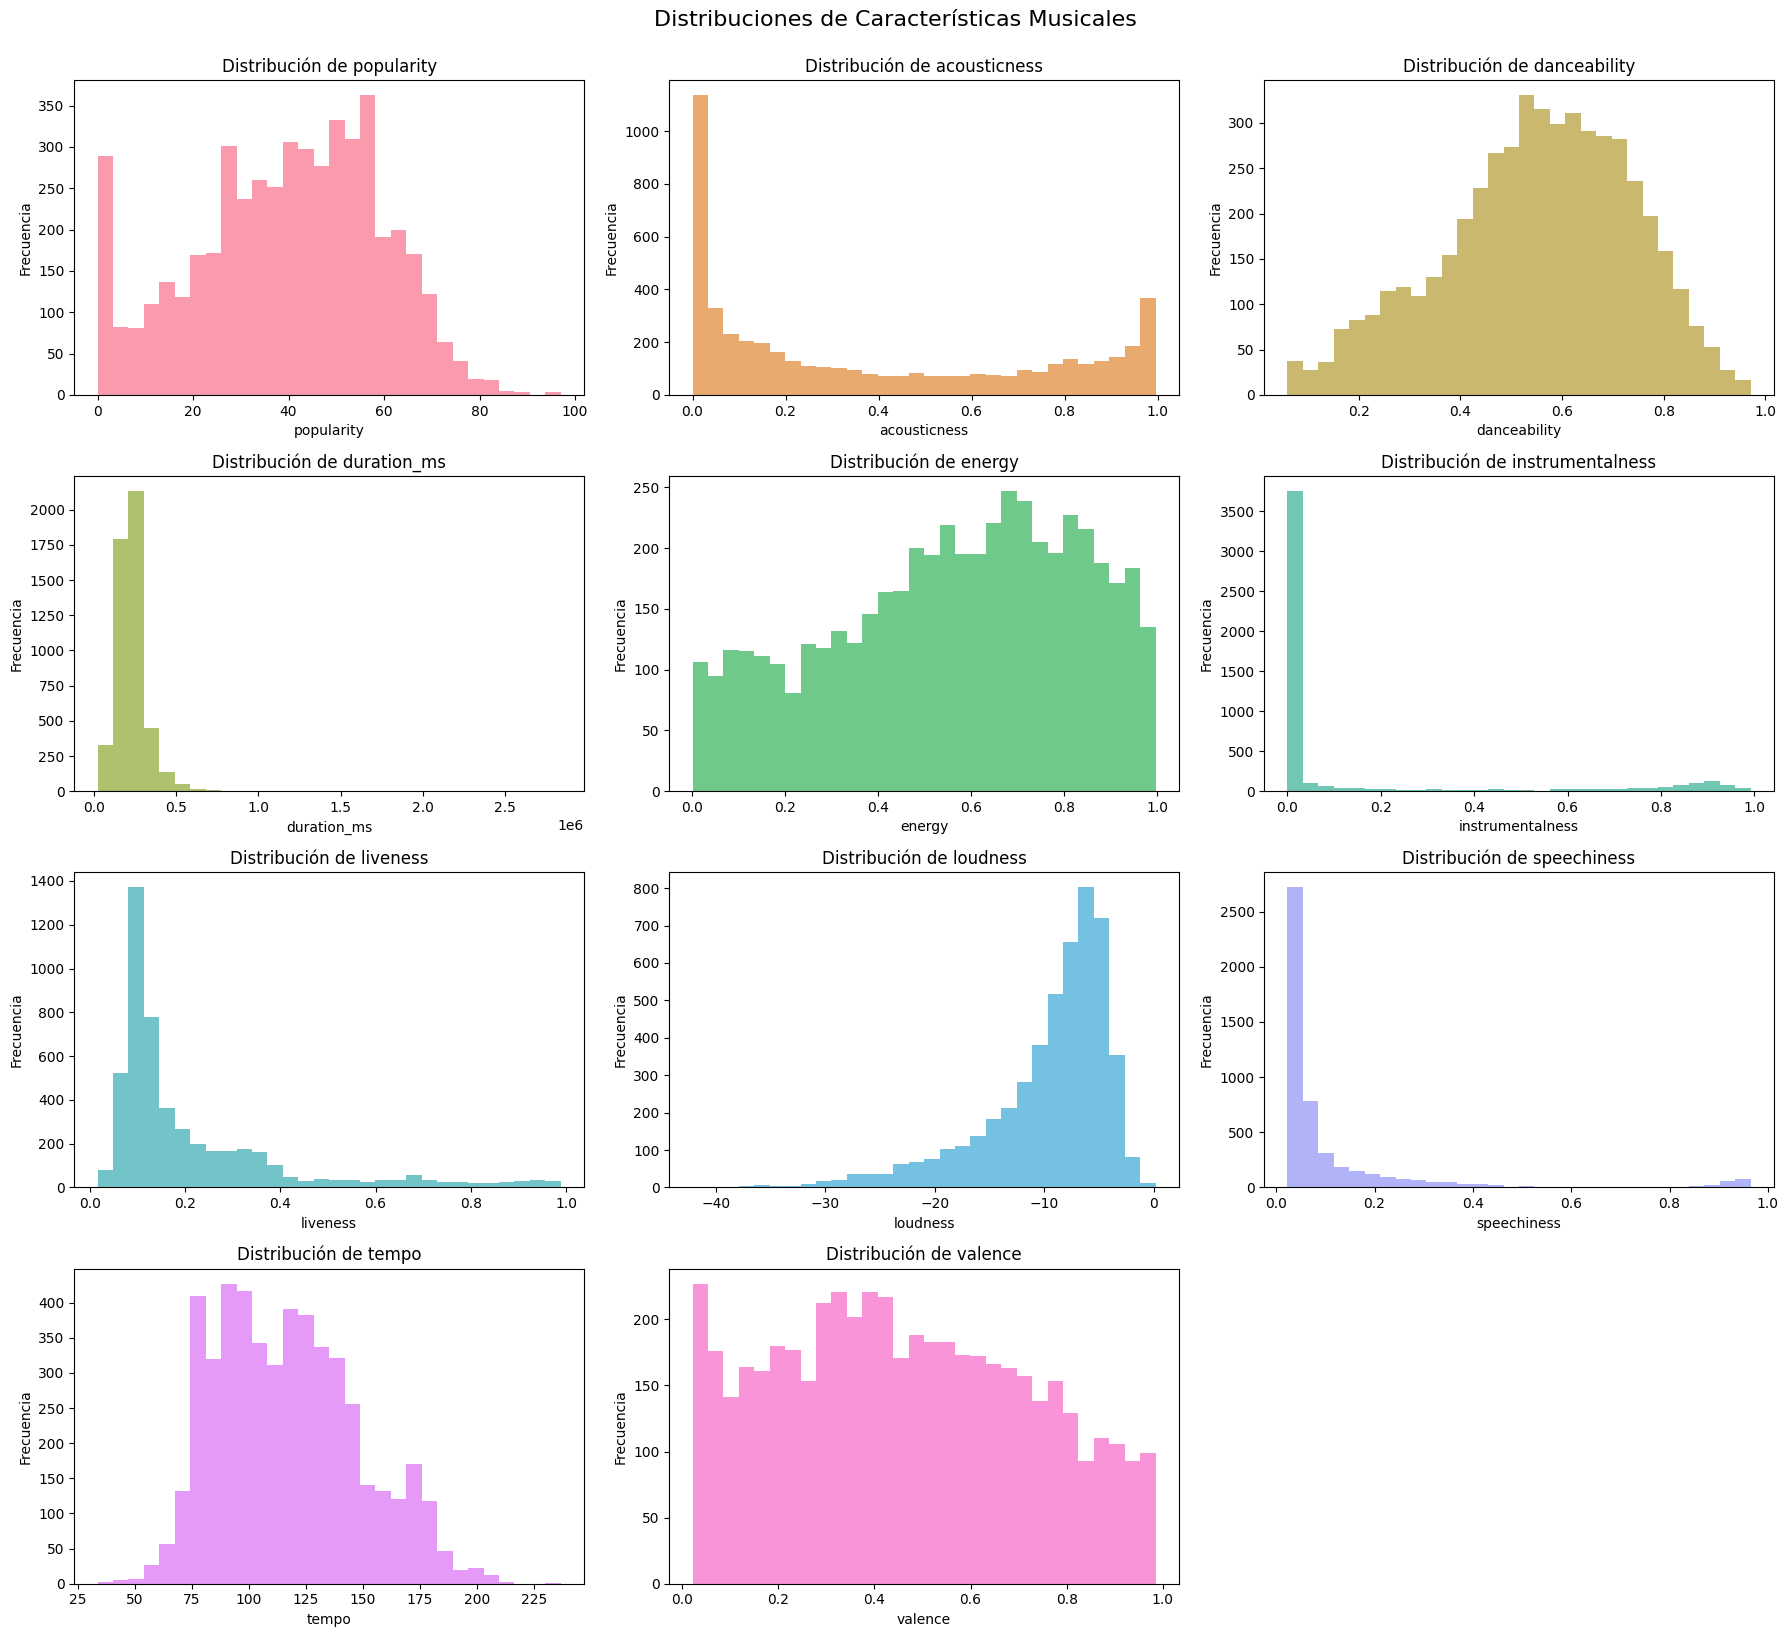


Distribución de géneros:
genre
Alternative         185
Anime               185
Blues               185
Comedy              185
Children's Music    185
Children’s Music    185
Classical           185
Dance               185
Country             185
Electronic          185
Folk                185
Rap                 185
Hip-Hop             185
Indie               185
Jazz                185
Movie               185
Opera               185
Pop                 185
R&B                 185
Ska                 185
Reggae              185
Reggaeton           185
Rock                185
Soundtrack          185
Soul                185
World               185
A Capella           119
Name: count, dtype: int64


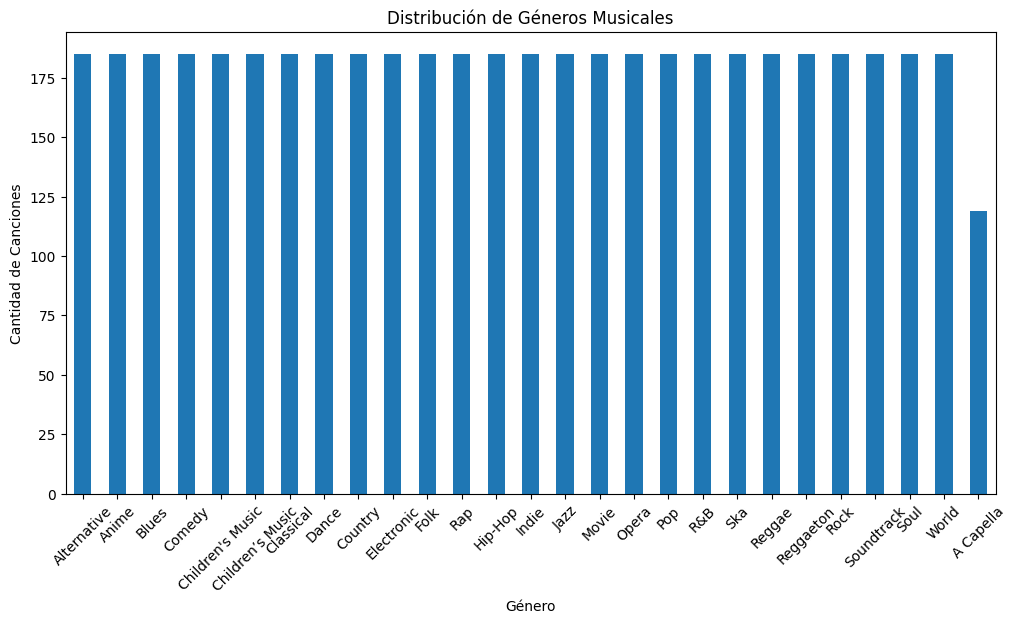

In [35]:
# Visualización de distribuciones
n_features = len(columnas_numericas)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Calcular filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 16))
axes = axes.ravel()

# Crear una paleta de colores con suficientes colores
colors = sns.color_palette("husl", n_features)

for i, feature in enumerate(columnas_numericas):
    axes[i].hist(df[feature], bins=30, alpha=0.7, color=colors[i])
    axes[i].set_title(f'Distribución de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')

# Ocultar subplots vacíos si los hay
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Distribuciones de Características Musicales', fontsize=16, y=1.02)
plt.show()

# Análisis de géneros
print("\nDistribución de géneros:")
genre_counts = df['genre'].value_counts()
print(genre_counts)

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Distribución de Géneros Musicales')
plt.xlabel('Género')
plt.ylabel('Cantidad de Canciones')
plt.xticks(rotation=45)
plt.show()

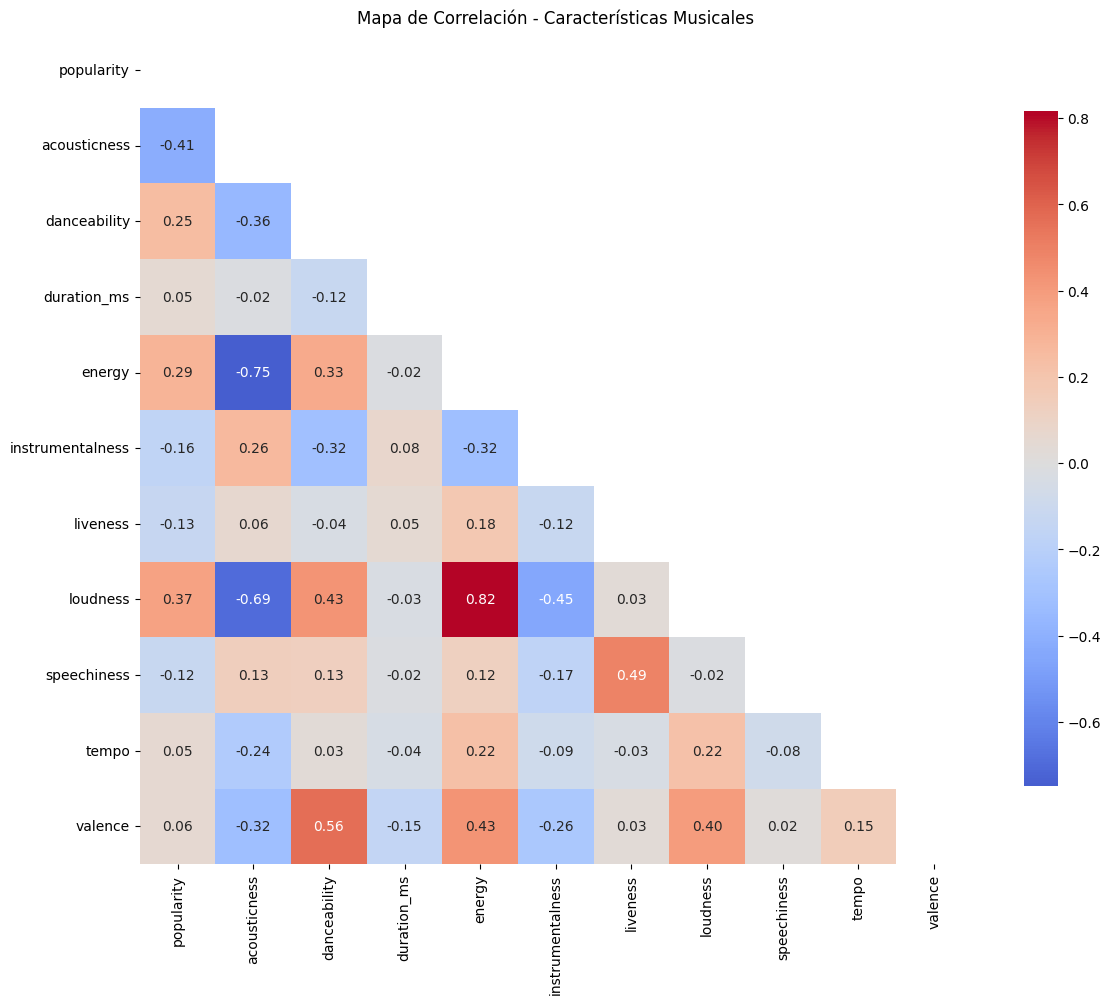

Correlaciones altas encontradas (>0.7):
  acousticness - energy: -0.748
  energy - loudness: 0.817


In [36]:

##NORMALIZACIÓN Y ANÁLISIS DE CORRELACIÓN

# Extraer solo las características numéricas
X = df[columnas_numericas].copy()

# Normalizar/estandarizar las variables
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)
X_normalizado_df = pd.DataFrame(X_normalizado, columns=columnas_numericas)

# Mapa de correlación
plt.figure(figsize=(12, 10))
correlation_matrix = X_normalizado_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': .8})
plt.title('Mapa de Correlación - Características Musicales')
plt.tight_layout()
plt.show()

# Identificar correlaciones altas
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'var1': correlation_matrix.columns[i],
                'var2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("Correlaciones altas encontradas (>0.7):")
    for pair in high_corr_pairs:
        print(f"  {pair['var1']} - {pair['var2']}: {pair['correlation']:.3f}")
else:
    print("No se encontraron correlaciones muy altas (>0.7)")

Varianza que explica cada componente:
  Componente 1: 0.323 (32.3%)
  Componente 2: 0.151 (15.1%)
  Componente 3: 0.111 (11.1%)
  Componente 4: 0.093 (9.3%)
  Componente 5: 0.076 (7.6%)
  Componente 6: 0.069 (6.9%)
  Componente 7: 0.063 (6.3%)
  Componente 8: 0.045 (4.5%)
  Componente 9: 0.033 (3.3%)
  Componente 10: 0.025 (2.5%)
  Componente 11: 0.010 (1.0%)


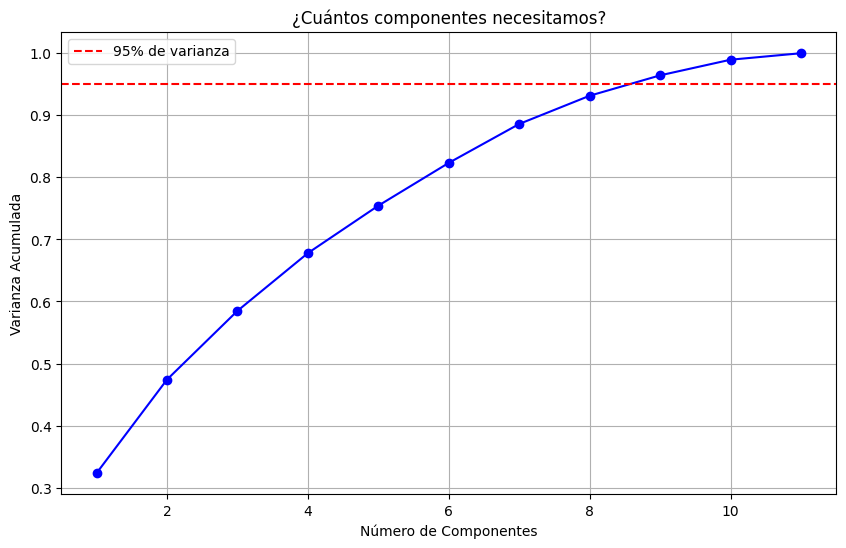

Componentes necesarios para 95% de varianza: 9
Reducimos de 11 a 9 dimensiones
PCA aplicado: conservamos 96.4% de la información


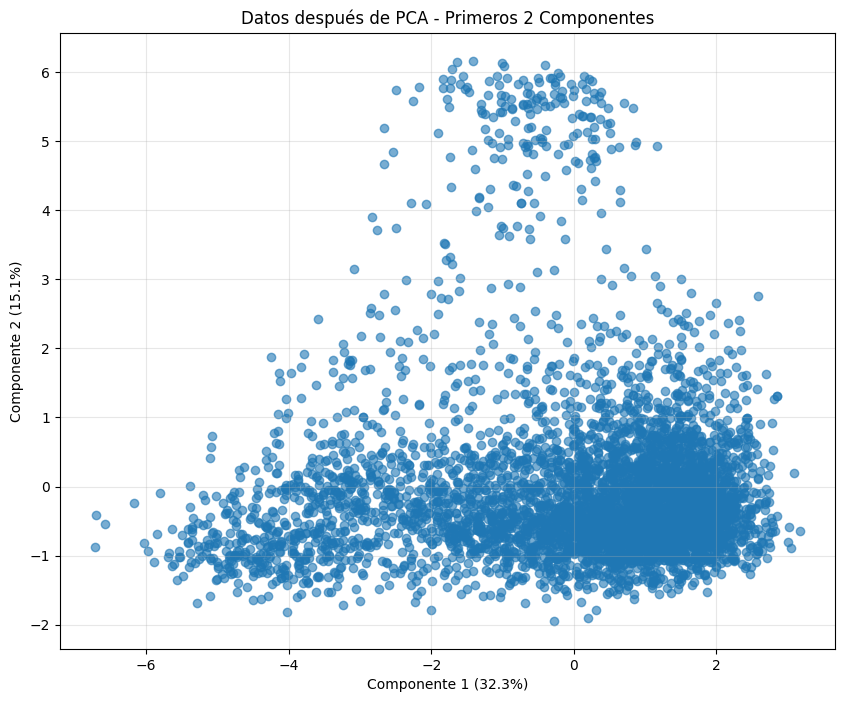

In [37]:
#REDUCCIÓN DE DIMENSIONALIDAD CON PCA

# Aplicar PCA para ver cuánta información podemos conservar
pca_completo = PCA()  # Sin límite de componentes
X_pca_completo = pca_completo.fit_transform(X_normalizado)

# Ver cuánta varianza explica cada componente
varianza_explicada = pca_completo.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

print("Varianza que explica cada componente:")
for i, var in enumerate(varianza_explicada):
    print(f"  Componente {i+1}: {var:.3f} ({var*100:.1f}%)")

# Gráfico de varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(varianza_acumulada)+1), varianza_acumulada, 'bo-')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% de varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('¿Cuántos componentes necesitamos?')
plt.legend()
plt.grid(True)
plt.show()

# Encontrar cuántos componentes necesitamos para 95% de varianza
componentes_95 = np.argmax(varianza_acumulada >= 0.95) + 1
print(f"Componentes necesarios para 95% de varianza: {componentes_95}")
print(f"Reducimos de {len(columnas_numericas)} a {componentes_95} dimensiones")

# Aplicar PCA con el número seleccionado de componentes
pca_final = PCA(n_components=componentes_95)
X_pca = pca_final.fit_transform(X_normalizado)

print(f"PCA aplicado: conservamos {varianza_acumulada[componentes_95-1]:.1%} de la información")

# Visualizar los primeros 2 componentes
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel(f'Componente 1 ({varianza_explicada[0]:.1%})')
plt.ylabel(f'Componente 2 ({varianza_explicada[1]:.1%})')
plt.title('Datos después de PCA - Primeros 2 Componentes')
plt.grid(True, alpha=0.3)
plt.show()

In [44]:
#CLUSTERING CON K-MEANS

#Definir el numero de Cluster
k = 3

# Aplicar K-means directamente
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_finales = kmeans.fit_predict(X_pca)

# Evaluar qué tan bueno es nuestro clustering
score = silhouette_score(X_pca, clusters_finales)
print(f"✅ Clustering completado!")
print(f"   Calidad del agrupamiento: {score:.3f}")

# Explicar el score de forma simple
if score > 0.5:
    print("¡Excelente! Los grupos están muy bien definidos")
elif score > 0.3:
    print("Bien! Los grupos son aceptables")
else:
    print("Los grupos no están muy claros, pero sigamos...")

# Agregar los clusters al dataframe original
df['cluster'] = clusters_finales

# Ver cuántas canciones hay en cada cluster
print(f"\nDistribución de las {len(df)} canciones en {k} grupos:")
for i in range(k):
    cantidad = sum(clusters_finales == i)
    porcentaje = cantidad / len(df) * 100
    print(f"  Grupo {i}: {cantidad} canciones ({porcentaje:.1f}%)")

✅ Clustering completado!
   Calidad del agrupamiento: 0.326
Bien! Los grupos son aceptables

Distribución de las 4929 canciones en 3 grupos:
  Grupo 0: 3521 canciones (71.4%)
  Grupo 1: 1189 canciones (24.1%)
  Grupo 2: 219 canciones (4.4%)


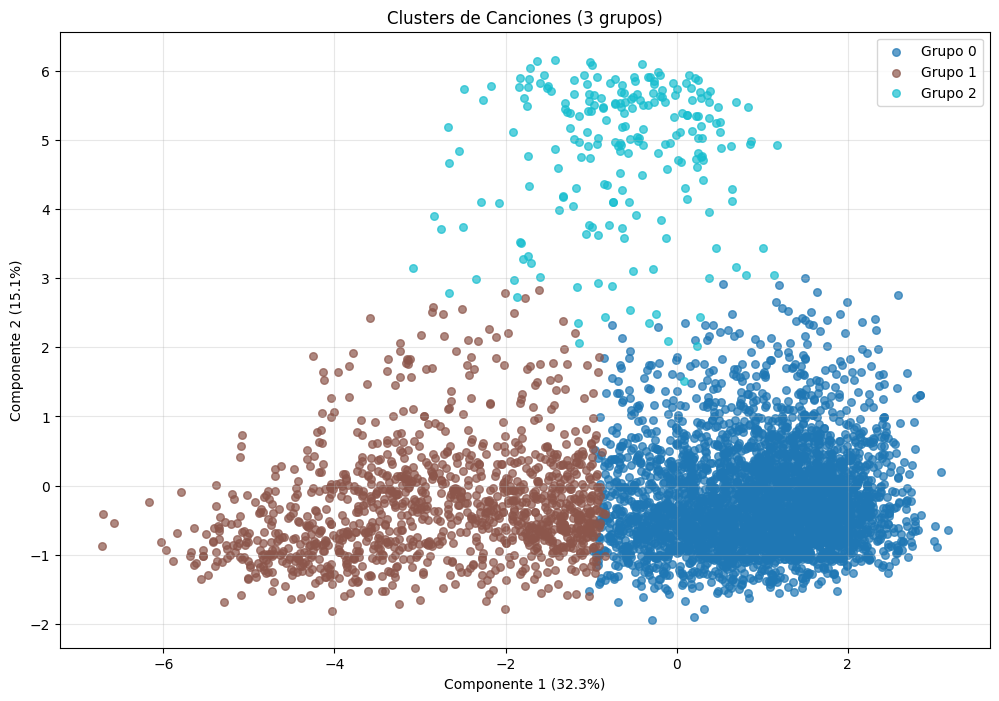

Características musicales promedio por grupo:
         popularity  acousticness  danceability  duration_ms  energy  \
cluster                                                                
0            45.261         0.206         0.611   230350.824   0.676   
1            26.556         0.837         0.374   233910.548   0.212   
2            21.498         0.775         0.565   237431.900   0.621   

         instrumentalness  liveness  loudness  speechiness    tempo  valence  
cluster                                                                       
0                   0.068     0.201    -6.982        0.095  122.038    0.538  
1                   0.373     0.169   -17.011        0.054  106.364    0.238  
2                   0.000     0.703   -12.298        0.864   98.625    0.415  


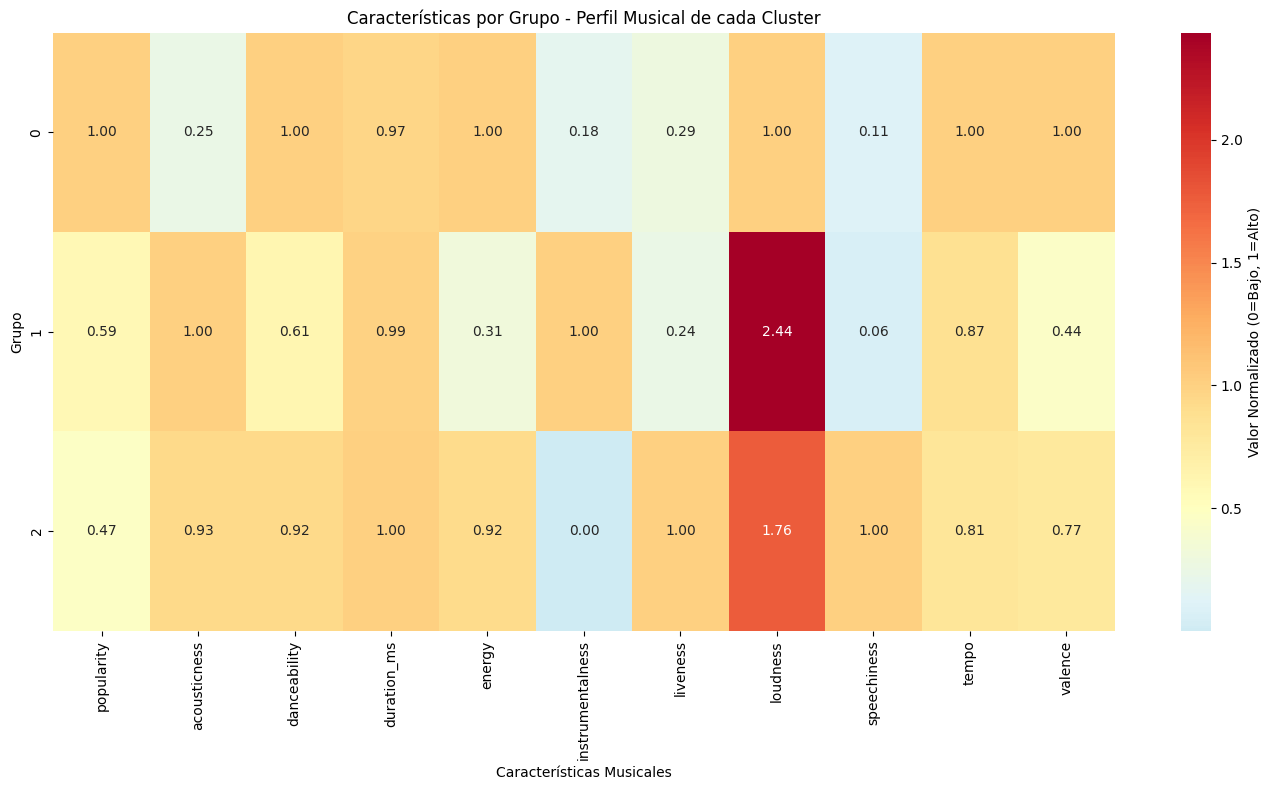


GRUPO 0 (3521 canciones):
  1. Dance: 183 canciones (5.2%)
  2. Reggae: 183 canciones (5.2%)
  3. Reggaeton: 183 canciones (5.2%)
Características altas: duration_ms, tempo, popularity

GRUPO 1 (1189 canciones):
  1. Opera: 182 canciones (15.3%)
  2. Soundtrack: 176 canciones (14.8%)
  3. Classical: 171 canciones (14.4%)
Características altas: duration_ms, tempo, popularity

GRUPO 2 (219 canciones):
  1. Comedy: 177 canciones (80.8%)
  2. Children's Music: 13 canciones (5.9%)
  3. Movie: 10 canciones (4.6%)
Características altas: duration_ms, tempo, popularity


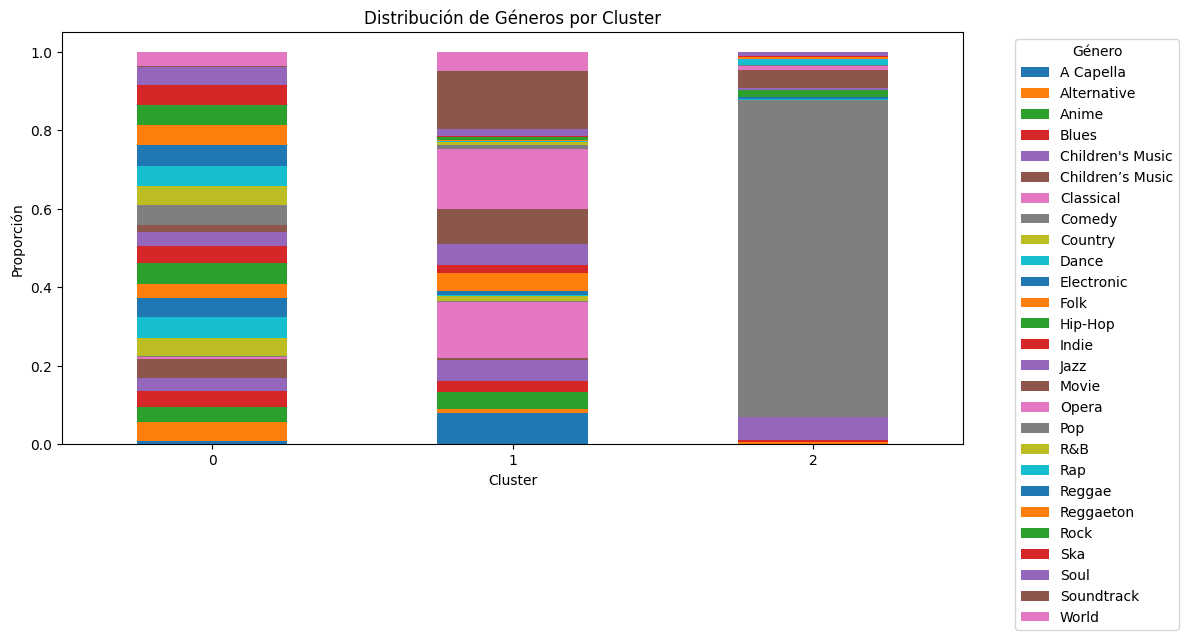

In [49]:
# VISUALIZAR LOS CLUSTERS


# Gráfico de clusters en 2D
plt.figure(figsize=(12, 8))
colores = plt.cm.tab10(np.linspace(0, 1, k))

for i in range(k):
    mask = clusters_finales == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colores[i]], label=f'Grupo {i}', alpha=0.7, s=30)

plt.xlabel(f'Componente 1 ({varianza_explicada[0]:.1%})')
plt.ylabel(f'Componente 2 ({varianza_explicada[1]:.1%})')
plt.title(f'Clusters de Canciones ({k} grupos)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ANALIZAR QUÉ REPRESENTAN LOS CLUSTERS

# Calcular características promedio por cluster
caracteristicas_por_cluster = df.groupby('cluster')[columnas_numericas].mean()

print("Características musicales promedio por grupo:")
print(caracteristicas_por_cluster.round(3))

# Visualizar las diferencias entre clusters con mapa de calor
plt.figure(figsize=(14, 8))
caracteristicas_normalizadas = caracteristicas_por_cluster.div(caracteristicas_por_cluster.max())

sns.heatmap(caracteristicas_normalizadas, annot=True, cmap='RdYlBu_r', 
            center=0.5, fmt='.2f', cbar_kws={'label': 'Valor Normalizado (0=Bajo, 1=Alto)'})
plt.title('Características por Grupo - Perfil Musical de cada Cluster')
plt.ylabel('Grupo')
plt.xlabel('Características Musicales')
plt.tight_layout()
plt.show()

# ANÁLISIS DE GÉNEROS POR CLUSTER

for i in range(k):
    cluster_data = df[df['cluster'] == i]
    genero_mas_comun = cluster_data['genre'].value_counts()
    
    print(f"\nGRUPO {i} ({len(cluster_data)} canciones):")
    
    # Mostrar top 3 géneros del cluster
    for j, (genero, cantidad) in enumerate(genero_mas_comun.head(3).items()):
        porcentaje = cantidad / len(cluster_data) * 100
        print(f"  {j+1}. {genero}: {cantidad} canciones ({porcentaje:.1f}%)")
    
    # Características más destacadas del cluster
    cluster_stats = caracteristicas_por_cluster.loc[i]
    top_caracteristicas = cluster_stats.nlargest(3)
    print(f"Características altas: {', '.join(top_caracteristicas.index)}")

# Visualizar distribución de géneros por cluster
plt.figure(figsize=(14, 8))
genero_cluster_crosstab = pd.crosstab(df['cluster'], df['genre'])
genero_cluster_proportions = genero_cluster_crosstab.div(genero_cluster_crosstab.sum(axis=1), axis=0)

genero_cluster_proportions.plot(kind='bar', stacked=True, ax=plt.gca(), figsize=(12, 6))
plt.title('Distribución de Géneros por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proporción')
plt.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [52]:
# RESUMEN FINAL DEL ANÁLISIS

print(f"Dataset analizado: {len(df)} canciones")
print(f"Características utilizadas: {len(columnas_numericas)} features musicales")
print(f"Clusters identificados: {k} grupos distintos")
print(f"Calidad del clustering: {score:.3f} (Silhouette Score)")

if score > 0.5:
    calidad = "Excelente"
elif score > 0.3:
    calidad = "Buena"
else:
    calidad = "Aceptable"

print(f"Interpretación: {calidad} separación entre grupos")

print(f"\n CONCLUSIONES:")
print(f"   • Cada cluster tiene un perfil musical único")
print(f"   • Los géneros tienden a agruparse por características similares")
print(f"   • PCA permitió reducir la complejidad manteniendo {varianza_acumulada[componentes_95-1]:.1%} de información")
print(f"   • Los clusters pueden usarse para recomendaciones musicales")

Dataset analizado: 4929 canciones
Características utilizadas: 11 features musicales
Clusters identificados: 3 grupos distintos
Calidad del clustering: 0.326 (Silhouette Score)
Interpretación: Buena separación entre grupos

 CONCLUSIONES:
   • Cada cluster tiene un perfil musical único
   • Los géneros tienden a agruparse por características similares
   • PCA permitió reducir la complejidad manteniendo 96.4% de información
   • Los clusters pueden usarse para recomendaciones musicales
